# Анализ эффективности двух вариантов посадочной страницы сайта турагенства с помощью A/B тестирования

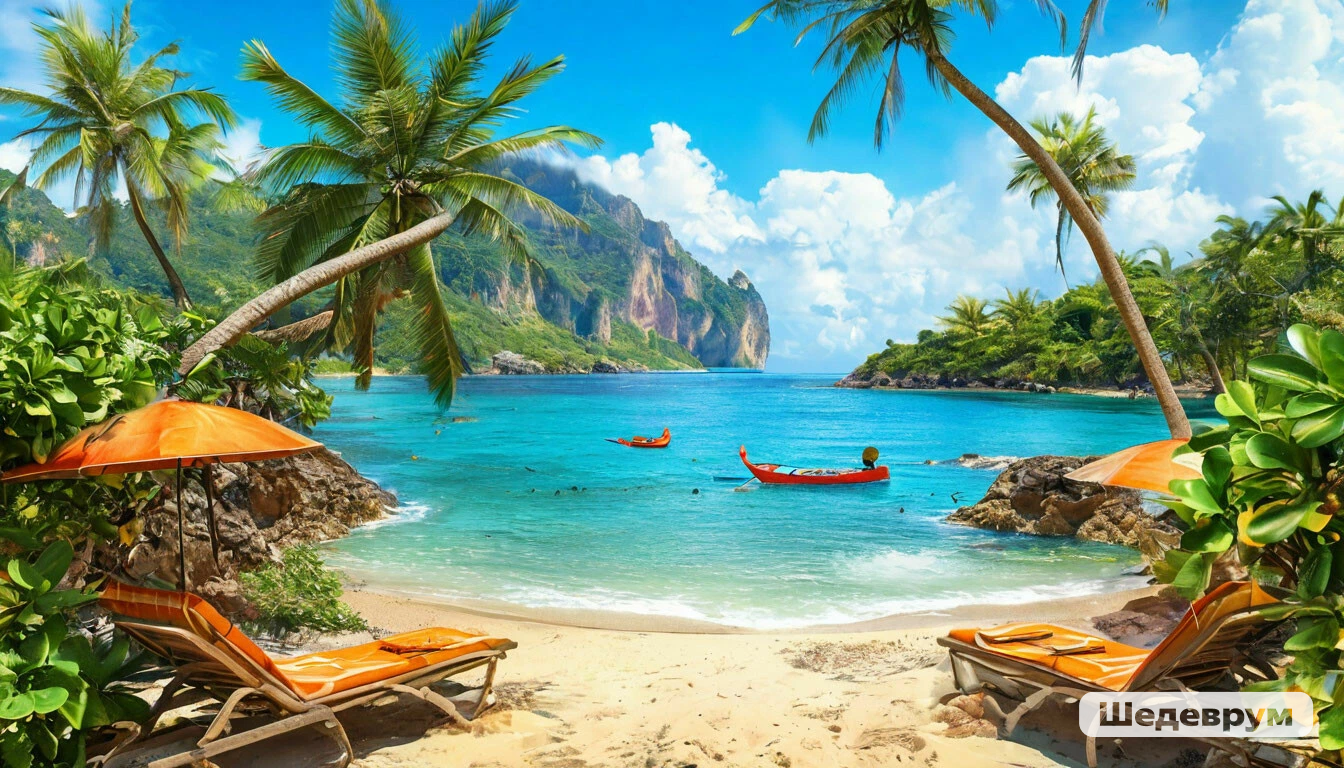\
Изображение сгенерировано "[Шедеврум](https://shedevrum.ai/)" по описанию:\
"*A/B тест посадочной страницы турагентства*"

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_10/ab_test.ipynb

## Оглавление

- [Постановка задачи](#about_task)
- [Загрузка и описание данных](#load_data) 
- [Анализ и предобработка данных](#prepare_data) 
- [Предварительный анализ результатов A/B-тестирования](#data_analysis) 
- [Анализ данных на предмет стабилизации метрик](#st_metrics) 
- [Статистический анализ результатов A/B-тестирования](#stat_tests) 
    - [Анализ метрики конверсии](#conv) 
        - [Проведение статистического теста (Z-критерий для пропорций)](#conv_test) 
        - [Построение 95%-х доверительных интервалов для метрики конверсии каждой группы](#conv_int) 
        - [Построение 95%-го доверительного интервала разницы конверсий в группах](#conv_int_diff) 
    - [Анализ метрики среднего чека](#avg_bill) 
        - [Анализ характера распределения ежедневного среднего чека в группах A и B](#avg_bill_distr) 
        - [Проведение статистического теста (двувыборочный T-тест)](#avg_bill_test) 
        - [Построение 95%-х доверительных интервалов для метрики среднего чека в каждой группе](#avg_bill_int) 
- [Общий вывод по результатам A/B теста](#results) 

## Постановка задачи <a class="anchor" id="about_task"></a>

Туристическая фирма планирует запустить новую акцию, чтобы продать как можно больше туров. \
Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. \
В результате эксперимента были собраны необходимые данные.

Необходимо определить, какой вариант посадочной страницы более предпочтителен \
по метрикам конверсии покупки и ежедневного среднего чека.

## Загрузка и описание данных <a class="anchor" id="load_data"></a>

In [3]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import shapiro, ttest_ind, t
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import (
    print_stat_test_result,
    print_shapiro_test_result,
    print_confidence_interval,
    display_confidence_intervals,
    get_tour_type,
    get_confidence_interval_of_difference_conversions,
)

Загрузим данные A/B теста.

In [4]:
data = pd.read_csv('./data/ab_data_tourist.csv')

data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


**Описание столбцов:**

- `user_id` — идентификатор пользователя, зашедшего на сайт;
- `data` — дата посещения сайта;
- `group` — группа теста (контрольная — А или тестовая — B);
- `purchase` — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
- `price` — цена купленного тура (если покупка не состоялась, цена равна 0).

    Компания предлагает следующие варианты туров:
    - Таиланд — 100 000 рублей;
    - Турция — 60 000 рублей;
    - Мальдивы — 200 000 рублей;
    - Санкт-Петербург — 10 000 рублей;
    - Камчатка — 150 000 рублей.

## Анализ и предобработка данных <a class="anchor" id="prepare_data"></a>

**Проверим наличие пропусков.**

In [5]:
data.isna().sum()

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

> Пропусков в таблице нет.

**Посмотрим на типы столбцов в таблице.**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


> Столбцы имеют корректный для своего значения тип кроме столбца `date`.\
Преобразуем его к типу `datetime`.

In [7]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

**Посмотрим, какая длительность проведения теста в каждой из групп.**

In [8]:
# Данные группы A
a_group_data = data[data['group'] == 'A']
# Множество уникальных дат проведения теста А
a_group_dates = set(a_group_data['date'])

# Данные группы B
b_group_data = data[data['group'] == 'B']
# Множество уникальных дат проведения теста B
b_group_dates = set(b_group_data['date'])

print(
    'Длительность проведения теста для группы A:',
    f'Начало теста: {str(min(a_group_dates))}',
    f'Конец теста: {str(max(a_group_dates))}',
    f'Количество дней: {len(a_group_dates)}',
    sep='\n',
)
print()
print(
    'Длительность проведения теста для группы B:',
    f'Начало теста: {str(min(b_group_dates))}',
    f'Конец теста: {str(max(b_group_dates))}',
    f'Количество дней: {len(b_group_dates)}',
    sep='\n',
)

Длительность проведения теста для группы A:
Начало теста: 2021-01-02 00:00:00
Конец теста: 2021-01-24 00:00:00
Количество дней: 23

Длительность проведения теста для группы B:
Начало теста: 2021-01-02 00:00:00
Конец теста: 2021-01-24 00:00:00
Количество дней: 23


> Видим, что условия сроков проведения теста идентичные для обеих групп.

**Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе группы.**

In [9]:
# Уникальные идентификторы пользователей группы A
a_user_ids = set(a_group_data['user_id'])

# Уникальные идентификторы пользователей группы B
b_user_ids = set(b_group_data['user_id'])

# Пересечение идентификаторов пользователей в группах А и B
ab_user_ids = a_user_ids & b_user_ids
print(f'Количество пользователей, которые попапли одновременно в обе группы: {len(ab_user_ids)}')

Количество пользователей, которые попапли одновременно в обе группы: 1895


Есть пользователи, которые попали в обе группы. \
Удалим их из обеих групп.

In [10]:
# Маска для удаления пользователей, попавших в обе группы, из группы A
mask = a_group_data['user_id'].isin(ab_user_ids)

# Удалим общих пользователей из группы А по маске
a_group_data = a_group_data.drop(a_group_data[mask].index) 

In [11]:
# Маска для удаления пользователей, попавших в обе группы, из группы B
mask = b_group_data['user_id'].isin(ab_user_ids)

# Удалим общих пользователей из группы B по маске
b_group_data = b_group_data.drop(b_group_data[mask].index)

> Итого, мы удалили обнаруженных общих пользователей из обеих групп.

## Предварительный анализ результатов A/B-тестирования <a class="anchor" id="data_analysis"></a>

**Рассчитаем некоторые вспомогательные показатели для контрольной и тестовой групп.**

Вспомним содержимое таблиц `a_group_data` и `b_group_data`.

In [12]:
a_group_data.head(3)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000


In [13]:
b_group_data.head(3)

,user_id,date,group,purchase,price
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
6,679687,2021-01-19,B,1,10000


In [14]:
ab_summary_data = pd.concat([
    # Объединим данные таблиц с группами A и B
    a_group_data,
    b_group_data
    # Сделаем группировку по группе и далее агрегацию по признакам
], ignore_index=True).groupby('group').agg(
    # Количество посещений сайта
    visits_count=('user_id', 'count'), 
    # Суммарное количество совершенных покупок
    purchases_count=('purchase', 'sum'), 
    # Суммарная стоимость всех покупок
    total_cost_of_all_purchases=('price', 'sum'), 
)
ab_summary_data

,visits_count,purchases_count,total_cost_of_all_purchases
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Сравним на графиках полученные значения для обеих групп.

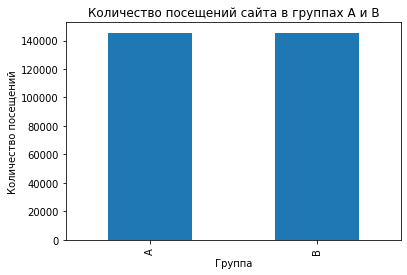

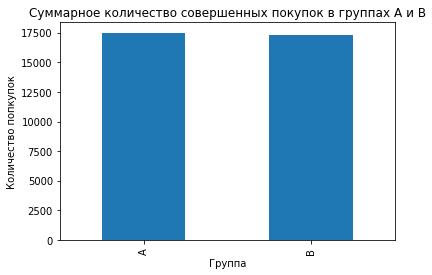

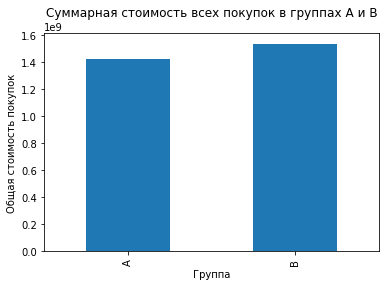

In [15]:
ab_summary_data.plot(
    y=['visits_count'], 
    kind='bar', 
    title='Количество посещений сайта в группах A и B',
    legend=False,
    xlabel='Группа',
    ylabel='Количество посещений',
);

ab_summary_data.plot(
    y=['purchases_count'], 
    kind='bar', 
    title='Cуммарное количество совершенных покупок в группах A и B',
    legend=False,
    xlabel='Группа',
    ylabel='Количество попкупок',
);

ab_summary_data.plot(
    y=['total_cost_of_all_purchases'], 
    kind='bar', 
    title='Суммарная стоимость всех покупок в группах A и B',
    legend=False,
    xlabel='Группа',
    ylabel='Общая стоимость покупок',
);

> По графикам видно, что: 
> - Количество посещений сайта в обеих группах примерно одинаковое, выборки сбалансированы.
> - Количество покупок в группах примерно одинаковое.
> - Суммарная стоимость покупок немного больше в группе B.

**Рассчитаем конверсию и средний чек в обеих группах.**

In [16]:
# Конверсия
ab_summary_data['conversion'] = \
    ab_summary_data['purchases_count'] / ab_summary_data['visits_count'] * 100

# Средний чек
ab_summary_data['average_bill'] = \
    ab_summary_data['total_cost_of_all_purchases'] / ab_summary_data['purchases_count']

ab_summary_data

,visits_count,purchases_count,total_cost_of_all_purchases,conversion,average_bill
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


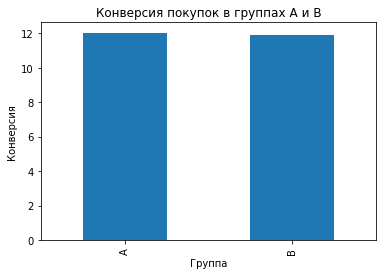

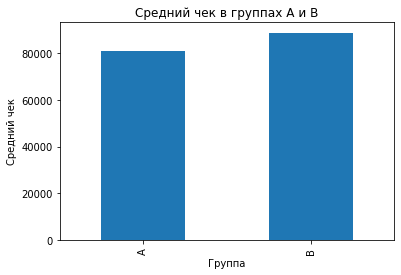

In [17]:
ab_summary_data.plot(
    y=['conversion'], 
    kind='bar', 
    title='Конверсия покупок в группах A и B',
    legend=False,
    xlabel='Группа',
    ylabel='Конверсия',
);

ab_summary_data.plot(
    y=['average_bill'], 
    kind='bar', 
    title='Средний чек в группах A и B',
    legend=False,
    xlabel='Группа',
    ylabel='Средний чек',
);

> Видно, конверсия в группах примерно одинаковая.\
А средний чек больше в группе B.

**Сравним группы A и B по покупательской способности каждого из туров.**

Вспомним цены туров:

- Таиланд — 100 000 рублей;
- Турция — 60 000 рублей;
- Мальдивы — 200 000 рублей;
- Санкт-Петербург — 10 000 рублей;
- Камчатка — 150 000 рублей.

Добавим столбец `tour_type` с типом тура, который определим по его цене.

In [18]:
# Определим поле с типом тура в обеих таблицах
a_group_data['tour_type'] = a_group_data['price'].apply(get_tour_type)
b_group_data['tour_type'] = b_group_data['price'].apply(get_tour_type)

In [19]:
# Посчитаем количество покупок каждого тура в группе A
a_tour_data = a_group_data.groupby('tour_type').agg(
    purchases_count_a=('purchase', 'sum')
)
a_tour_data

,purchases_count_a
tour_type,
Kamchatka,3478
Maldives,1724
Saint Petersburg,5182
Thailand,1832
Türkiye,5271


In [20]:
# Посчитаем количество покупок каждого тура в группе B
b_tour_data = b_group_data.groupby('tour_type').agg(
    purchases_count_b=('purchase', 'sum')
)
b_tour_data

,purchases_count_b
tour_type,
Kamchatka,3438
Maldives,1694
Saint Petersburg,5201
Thailand,5227
Türkiye,1730


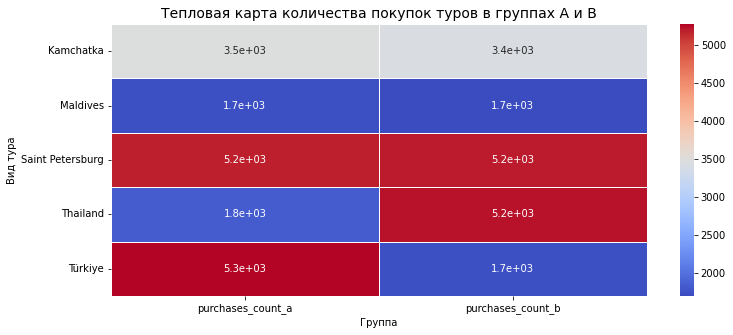

In [21]:
# Объединяем таблицы по вертикали
ab_tours_data = pd.concat([a_tour_data, b_tour_data], axis=1)

# Построим тепловую карту полученной таблицы

# Фигура и координатная плоскость
fig, axes = plt.subplots(figsize=(12, 5))

# Параметры тепловой карты
sns.heatmap(
    ab_tours_data, 
    annot=True, 
    linewidths=.9, 
    ax=axes, 
    cmap='coolwarm'
)
plt.title('Тепловая карта количества покупок туров в группах A и B', fontsize=14)
plt.xlabel('Группа')
plt.ylabel('Вид тура')

# Выведем график
plt.show()

> Видно, что в группе B больше покупают туров в Тайланд.\
А в группе A больше покупают туров в Турцию.\
По остальным турам значения в группах не так сильно отличаются.

## Анализ данных на предмет стабилизации метрик <a class="anchor" id="st_metrics"></a>

Построим таблицу с ежедневными данными по обеим группам.\
Посчитаем количество посещений страницы, количество и сумму покупок.

In [22]:
ab_daily_data = pd.concat(
    # Соединим данные по группам А и В
    [a_group_data, b_group_data], ignore_index=True
    # Сгруппируем по дате и группе
).groupby(['date', 'group']).agg(
    # Количество посещений страницы
    visits_count=('user_id', 'count'),
    # Количество покупок
    purchases_count=('purchase', 'sum'),
    # Суммарная стоимость покупок
    total_cost_of_all_purchases=('price', 'sum'),
)
ab_daily_data.head(4)

visits_count  purchases_count  total_cost_of_all_purchases
date       group                                                            
2021-01-02 A              2854              359                     29410000
           B              2861              345                     29660000
2021-01-03 A              6596              748                     62000000
           B              6619              754                     65960000

Добавим столбцы  с конверсией и средним чеком.

In [23]:
# Конверсия
ab_daily_data['conversion'] = ab_daily_data['purchases_count'] / ab_daily_data['visits_count'] * 100

# Средний чек
ab_daily_data['average_bill'] = \
    ab_daily_data['total_cost_of_all_purchases'] / ab_daily_data['purchases_count']

ab_daily_data.head(4)

visits_count  purchases_count  total_cost_of_all_purchases  \
date       group                                                               
2021-01-02 A              2854              359                     29410000   
           B              2861              345                     29660000   
2021-01-03 A              6596              748                     62000000   
           B              6619              754                     65960000   

                  conversion  average_bill  
date       group                            
2021-01-02 A       12.578837  81922.005571  
           B       12.058721  85971.014493  
2021-01-03 A       11.340206  82887.700535  
           B       11.391449  87480.106101

Добавим столбцы с кумулятивными значениями посещений странцы, количества и суммы покупок.

In [24]:
# Кумулятивное количество посещений страницы
ab_daily_data['visits_count_cum'] = ab_daily_data.groupby('group')['visits_count'].cumsum()

# Кумулятивное количество покупок
ab_daily_data['purchases_count_cum'] = ab_daily_data.groupby('group')['purchases_count'].cumsum()

# Кумулятивная общая стоимость покупок
ab_daily_data['total_cost_of_all_purchases_cum'] = \
    ab_daily_data.groupby('group')['total_cost_of_all_purchases'].cumsum()

ab_daily_data.head(4)

visits_count  purchases_count  total_cost_of_all_purchases  \
date       group                                                               
2021-01-02 A              2854              359                     29410000   
           B              2861              345                     29660000   
2021-01-03 A              6596              748                     62000000   
           B              6619              754                     65960000   

                  conversion  average_bill  visits_count_cum  \
date       group                                               
2021-01-02 A       12.578837  81922.005571              2854   
           B       12.058721  85971.014493              2861   
2021-01-03 A       11.340206  82887.700535              9450   
           B       11.391449  87480.106101              9480   

                  purchases_count_cum  total_cost_of_all_purchases_cum  
date       group                                                        
2021-01-02 A                      359                         29410000  
           B                      345                         29660000  
2021-01-03 A                     1107                         91410000  
           B                     1099                         95620000

Теперь посчитаем кумулятивную конверсию и кумулятивный средний чек.

In [25]:
# Кумулятивная конверсия
ab_daily_data['conversion_cum'] = \
    ab_daily_data['purchases_count_cum'] / ab_daily_data['visits_count_cum'] * 100

# Кумулятивный средний чек
ab_daily_data['average_bill_cum'] = \
    ab_daily_data['total_cost_of_all_purchases_cum'] / ab_daily_data['purchases_count_cum']
    
ab_daily_data.head(4)

visits_count  purchases_count  total_cost_of_all_purchases  \
date       group                                                               
2021-01-02 A              2854              359                     29410000   
           B              2861              345                     29660000   
2021-01-03 A              6596              748                     62000000   
           B              6619              754                     65960000   

                  conversion  average_bill  visits_count_cum  \
date       group                                               
2021-01-02 A       12.578837  81922.005571              2854   
           B       12.058721  85971.014493              2861   
2021-01-03 A       11.340206  82887.700535              9450   
           B       11.391449  87480.106101              9480   

                  purchases_count_cum  total_cost_of_all_purchases_cum  \
date       group                                                         
2021-01-02 A                      359                         29410000   
           B                      345                         29660000   
2021-01-03 A                     1107                         91410000   
           B                     1099                         95620000   

                  conversion_cum  average_bill_cum  
date       group                                    
2021-01-02 A           12.578837      81922.005571  
           B           12.058721      85971.014493  
2021-01-03 A           11.714286      82574.525745  
           B           11.592827      87006.369427

Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

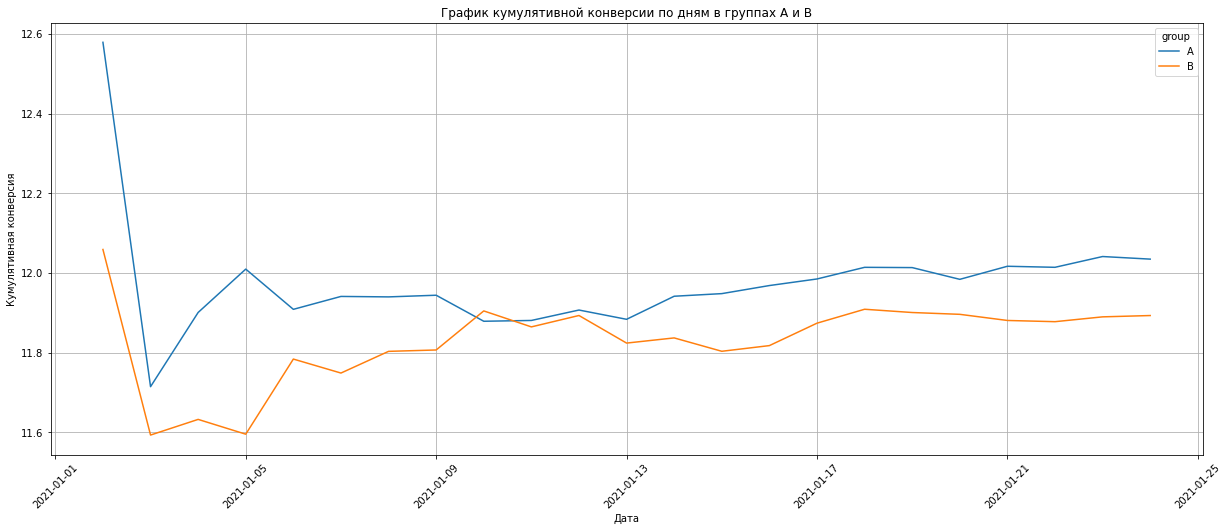

In [26]:
# Создаём фигуру размером 16 x 6
fig = plt.figure(figsize=(16, 6))

# Добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])

# Строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(data=ab_daily_data, x='date', y='conversion_cum', hue='group', ax=ax)

# Задаём подписи к графику
ax.set_title('График кумулятивной конверсии по дням в группах A и B')
ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивная конверсия')

# Поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)

# Отображение сетки
ax.grid(True);

> Кумулятивные метрики конверсии стабилизировались в группах, тест можно считать завершенным.\
Их графики идут приблизительно параллельно после 15.01.2021.\
Значение кумулятивной конверсии после 11.01.2021 в группе A стабильно выше, чем  в группе B.

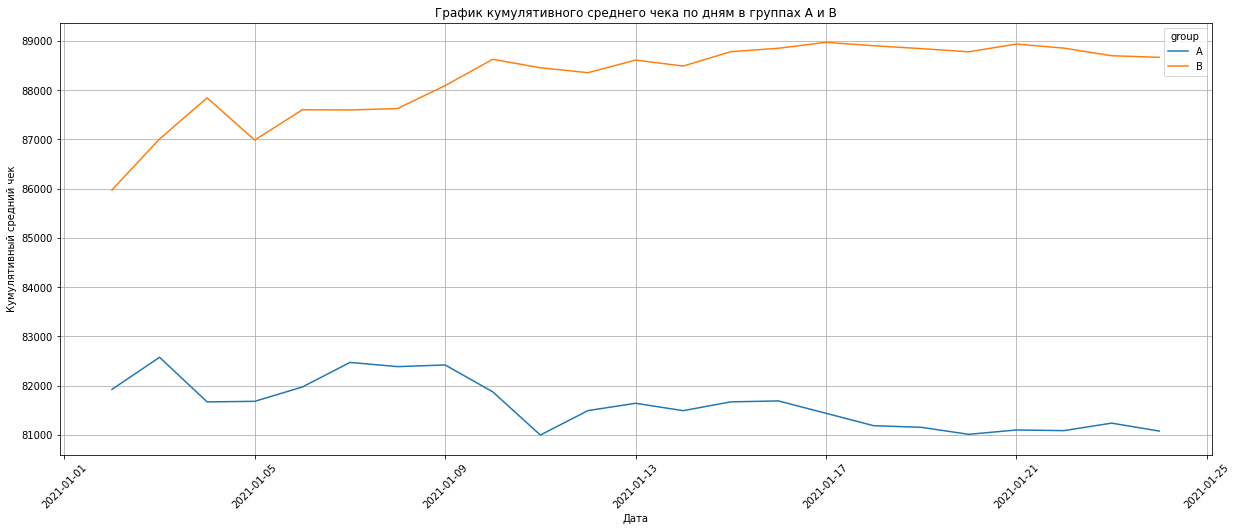

In [27]:
# Создаём фигуру размером 16 x 6
fig = plt.figure(figsize=(16, 6))

# Добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])

# Строим lineplot для кумулятивного среднего чека в каждой группе
sns.lineplot(data=ab_daily_data, x='date', y='average_bill_cum', hue='group', ax=ax)

# Задаём подписи к графику
ax.set_title('График кумулятивного среднего чека по дням в группах A и B')
ax.set_xlabel('Дата')
ax.set_ylabel('Кумулятивный средний чек')

# Задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)

# Задаём отображение сетки
ax.grid(True);

> Кумулятивные метрики конверсии стабилизировались в группах, тест можно считать завершенным.\
>Их графики идут приблизительно параллельно после 13.01.2021.\
>Значение кумулятивной конверсии с самого начала теста группе B стабильно выше, чем  в группе A.
>
> Возможно, это связано с тем, что в группе B больше покупают туров в Тайланд, \
>а в группе A больше покупают туров в Турцию.\
>При этом туры в Тайланд дороже, чем в Турцию.
>- Таиланд — 100 000 рублей;
> - Турция — 60 000 рублей;
>
>Поэтому несмотря на то, что в группе A больше конверсия, в группе B больше средний чек.

## Статистический анализ результатов A/B-тестирования <a class="anchor" id="stat_tests"></a>

### Анализ метрики конверсии <a class="anchor" id="conv"></a>

#### Проведение статистического теста (Z-критерий для пропорций) <a class="anchor" id="conv_test"></a>

Группы A и B независимы, признак конверсии является бинарным.\
Поэтому для определения статистической значимости результатов полученной конверсии \
воспользуемся Z-критерием для пропорций. 

Выше мы сформировали таблицу `ab_summary_data` с обобщенными результатами A/B теста.

In [28]:
ab_summary_data

,visits_count,purchases_count,total_cost_of_all_purchases,conversion,average_bill
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Столбцы содержат следующую информацию:
- `group` - группа;
- `visits_count` - количество посещений страницы;
- `purchases_count` - количество покупок;
- `total_cost_of_all_purchases` - общая стоимость покупок;
- `conversion` - конверсия;
- `average_bill` - средний чек.

Сформулируем нулевую и альтернативную гипотезы.

- **Нулевая гипотеза**: \
конверсии в группах A и B равны\
$H_0: p_a = p_b $

- **Альтернативная гипотеза**: \
конверсии в группах A и B различаются\
$H_1: p_a \neq p_b$

Уровень значимости $\alpha$ возьмем равным $0.05$.

In [29]:
# Уровень значимости
alpha = 0.05 

# Вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count = ab_summary_data['purchases_count'], # число «успехов»
    nobs = ab_summary_data['visits_count'], # общее число наблюдений
    alternative = 'two-sided',
)

# Выводим результаты теста
print_stat_test_result(p_value, alpha)

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу.


> В результате статистического теста можно сделать вывод, что конверсии в группах A и B не различаются.

#### Построение 95%-х доверительных интервалов для метрики конверсии каждой группы <a class="anchor" id="conv_int"></a>

Построим 95%-е доверительные интервалы для метрики конверсии в каждой из групп.

In [30]:
# Уровень надёжности
gamma = 0.95 

# Уровень значимости
alpha = 1 - gamma 

**Доверительный интервал для конверсии группы A**

In [31]:
# Вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
a_lower, a_upper = proportion_confint(
    count=ab_summary_data.loc['A']['purchases_count'], # количество успехов
    nobs=ab_summary_data.loc['A']['visits_count'], # количество наблюдений
    alpha=alpha # уровень значимости
)

print_confidence_interval(a_lower, a_upper, 5)

Доверительный интервал: (0.11867, 0.12202)


**Доверительный интервал для конверсии группы B**

In [32]:
# Вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
b_lower, b_upper = proportion_confint(
    count=ab_summary_data.loc['B']['purchases_count'], # количество успехов
    nobs=ab_summary_data.loc['B']['visits_count'], # количество наблюдений
    alpha=alpha # уровень значимости
)

print_confidence_interval(b_lower, b_upper, 5)

Доверительный интервал: (0.11726, 0.12059)


Отобразим полученные доверительные интревалы на графике.

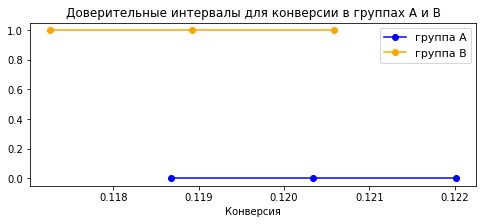

In [33]:
display_confidence_intervals(
    a_lower, a_upper,
    b_lower, b_upper,
    'Доверительные интервалы для конверсии в группах A и B',
    'Конверсия',
)

> Доверительные интревалы для групп пересекаются.\
Значит, существует вероятность, что истинное значение конверсии в обеих группах может совпасть (попасть в общую зону). \
Поэтому нельзя однозначно сказать, есть ли разница в конверсиях.

#### Построение 95%-го доверительного интервала разницы конверсий в группах <a class="anchor" id="conv_int_diff"></a>

Построим доверительный интервал разницы конверсий, который рассчитывается по следующей формуле.

$$ \Delta p = \Delta X_{p} \pm z_{крит} \times \sqrt{\frac{X_{p_a}(1-X_{p_a})}{n_a}+\frac{X_{p_b}(1-X_{p_b})}{n_b}} $$

Где:
- индексы $a$ и $b$ обозначают принадлежность параметра группе А и B соответственно;
- $\Delta p = p_{b}-p_{a}$ — истинная разница конверсий групп B и A;
- $\Delta X_{p} = X_{p_b}-X_{p_a}$ — выборочная разница конверсий групп B и A.

Код для расчета доверительного интервала разницы конверсий вынесен в функцию `get_confidence_interval_of_difference_conversions`.

Вспомним содержимое таблиц `a_group_data` и `b_group_data`.

In [34]:
a_group_data.head(3)

,user_id,date,group,purchase,price,tour_type
0,851104,2021-01-21,A,0,0,None
1,804228,2021-01-12,A,0,0,None
4,864975,2021-01-21,A,1,150000,Kamchatka


In [35]:
b_group_data.head(3)

,user_id,date,group,purchase,price,tour_type
2,661590,2021-01-11,B,0,0,None
3,853541,2021-01-08,B,0,0,None
6,679687,2021-01-19,B,1,10000,Saint Petersburg


In [36]:
# Сформируем параметры для функции

# Размеры выборок групп А и B
n = [a_group_data['user_id'].count(), b_group_data['user_id'].count()]

# Выборочная пропорция групп A и B
x_p = [a_group_data['purchase'].mean(), b_group_data['purchase'].mean()]

# Строим доверительный интервал для разности пропорций
lower_bound, upper_bound = get_confidence_interval_of_difference_conversions(x_p=x_p, n=n)

# Выводим результат
print_confidence_interval(lower_bound*100, upper_bound*100)

Доверительный интервал: (-0.38, 0.09)


> Интервал охватывает точку 0.\
Это означает, что варианты A и B равнозначны по метрике конверсии.

### Анализ метрики среднего чека <a class="anchor" id="avg_bill"></a>

#### Анализ характера распределения ежедневного среднего чека в группах A и B <a class="anchor" id="avg_bill_distr"></a>

Вспомним содержимое таблицы `ab_daily_data`.

In [37]:
ab_daily_data.head(4)

visits_count  purchases_count  total_cost_of_all_purchases  \
date       group                                                               
2021-01-02 A              2854              359                     29410000   
           B              2861              345                     29660000   
2021-01-03 A              6596              748                     62000000   
           B              6619              754                     65960000   

                  conversion  average_bill  visits_count_cum  \
date       group                                               
2021-01-02 A       12.578837  81922.005571              2854   
           B       12.058721  85971.014493              2861   
2021-01-03 A       11.340206  82887.700535              9450   
           B       11.391449  87480.106101              9480   

                  purchases_count_cum  total_cost_of_all_purchases_cum  \
date       group                                                         
2021-01-02 A                      359                         29410000   
           B                      345                         29660000   
2021-01-03 A                     1107                         91410000   
           B                     1099                         95620000   

                  conversion_cum  average_bill_cum  
date       group                                    
2021-01-02 A           12.578837      81922.005571  
           B           12.058721      85971.014493  
2021-01-03 A           11.714286      82574.525745  
           B           11.592827      87006.369427

Разделим таблицу `ab_daily_data` с ежедневными данными на отдельные таблицы \
с данными группы A и группы B.

In [38]:
# Маска для фильтрации данных группы A
mask_a = ab_daily_data.index.get_level_values('group') == 'A'
# Маска для фильтрации данных группы B
mask_b = ab_daily_data.index.get_level_values('group') == 'B'

# Данные для группы A
a_daily_data = ab_daily_data[mask_a]
# Данные для группы B
b_daily_data = ab_daily_data[mask_b]

Посмотрим на графики распределения среднего чека в группах A и B.

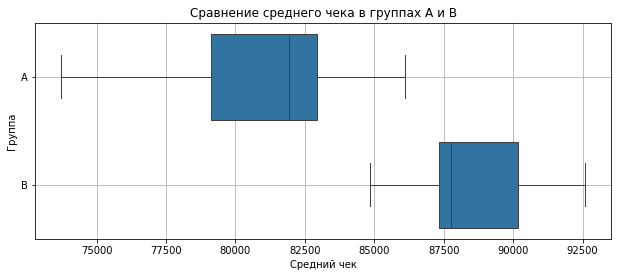

In [39]:
# Создаём фигуру размером 8x3
fig = plt.figure(figsize=(8, 3)) 

# Добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 

# Строим boxplot для среднего чека по признаку group
sns.boxplot(data=ab_daily_data.reset_index(), x='average_bill', y='group', ax=ax) 

# Подписи к графику
ax.set_title('Сравнение среднего чека в группах A и B')
ax.set_xlabel('Средний чек')
ax.set_ylabel('Группа')

# Отображение сетки
ax.grid(True);

По графику видно, что средний чек в группе B больше, чем в группе A.

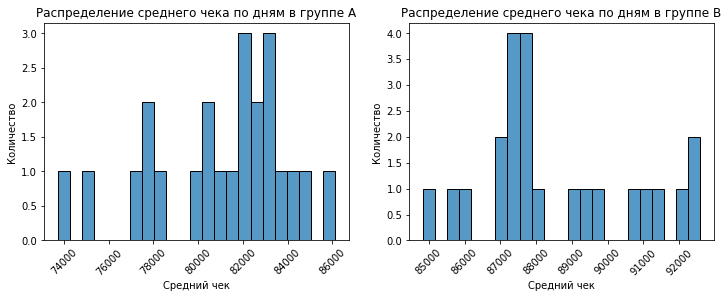

In [40]:
# Cоздаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Гистограммы гаспределения среднего чека в группах
sns.histplot(x='average_bill', data=a_daily_data, ax=axes[0], bins=23)
sns.histplot(x='average_bill', data=b_daily_data, ax=axes[1], bins=23)

# Поворот меток по оси OX
axes[0].xaxis.set_tick_params(rotation=45)
axes[1].xaxis.set_tick_params(rotation=45)

# Подписи к графикам
axes[0].set_title('Распределение среднего чека по дням в группе А')
axes[0].set_xlabel('Средний чек')
axes[0].set_ylabel('Количество')

axes[1].set_title('Распределение среднего чека по дням в группе B')
axes[1].set_xlabel('Средний чек')
axes[1].set_ylabel('Количество');

По графикам сложно сказать, являются ли распределения нормальными.\
Проверим это с помощью теста Шапиро-Уилка.

In [41]:
# Задаем уровень значимости
alpha = 0.05 

# Вычисляем результат теста Шапиро-Уилка для каждой группы
shapiro_result_a = shapiro(a_daily_data['average_bill'])
shapiro_result_b = shapiro(b_daily_data['average_bill'])

# Выведем результаты
print_shapiro_test_result(shapiro_result_a.pvalue, alpha, 'A')
print_shapiro_test_result(shapiro_result_b.pvalue, alpha, 'B')

p-value группы A: 0.25
Принимаем нулевую гипотезу. Распределение в группе A является нормальным.

p-value группы B: 0.09
Принимаем нулевую гипотезу. Распределение в группе B является нормальным.



> Распределение в обеих группах нормальное.

#### Проведение статистического теста (двувыборочный T-тест) <a class="anchor" id="avg_bill_test"></a>

Поскольку распределение в обеих группах является нормальным, мы можем применить двувыборочный T-тест.\
Сформулируем нулевую и альтернативную гипотезы.

- **Нулевая гипотеза**: \
средний чек пользователей из группы А \
больше  или равен среднему чеку пользователей из группы B:\
$ H_0: \mu_a >= \mu_b $

- **Альтернативная гипотеза**: \
средний чек пользователей из группы А \
меньше среднего чека пользователей из группы B:\
$ H_1: \mu_a < \mu_b $

In [42]:
# Задаем уровень значимости
alpha = 0.05 

# Вычисляем результат T-теста для групп
ttest_results = ttest_ind(
    a=a_daily_data['average_bill'],
    b=b_daily_data['average_bill'],
    # проверяем левостороннюю гипотезу, поэтому выбираем параметр less
    alternative='less',
)

# Выведем результаты теста
print_stat_test_result(ttest_results.pvalue, alpha)

p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной.


> По результатам теста можно сделать вывод, что средний чек в группе B больше, чем в группе A.

#### Построение 95%-х доверительных интервалов для метрики среднего чека в каждой группе <a class="anchor" id="avg_bill_int"></a>

Построим 95%-е доверительные интервалы для обеих групп.

**Доверительный интервал для среднего чека группы A**

In [43]:
# Размер выборки
n = len(a_daily_data) 

# Число степеней свободы
k = n - 1 

# Выборочное среднее
x_mean = a_daily_data['average_bill'].mean()

# Выборочное стандартное отклонение
x_std = a_daily_data['average_bill'].std()

# Уровень надёжности
gamma = 0.95 

# Уровень значимости
alpha = 1 - gamma 

# Строим доверительный интервал
a_lower, a_upper = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))

print_confidence_interval(a_lower, a_upper)

Доверительный интервал: (79630.35, 82308.22)


> Можем сделать вывод, что с надежностью 95% средний чек в группе A \
лежит в интервале от 79630.35 до 82308.22.

**Доверительный интервал для среднего чека группы B**

In [44]:
# Размер выборки
n = len(b_daily_data) 

# Число степеней свободы
k = n - 1 

# Выборочное среднее
x_mean = b_daily_data['average_bill'].mean()

# Выборочное стандартное отклонение
x_std = b_daily_data['average_bill'].std()

# Уровень надёжности
gamma = 0.95 

# Уровень значимости
alpha = 1 - gamma 

# Строим доверительный интервал
b_lower, b_upper = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))

print_confidence_interval(b_lower, b_upper)

Доверительный интервал: (87625.83, 89525.61)


> Можем сделать вывод, что с надежностью 95% средний чек в группе B \
лежит в интервале от 87625.83 до 89525.61.

Отобразим доверительные интервалы на графике.

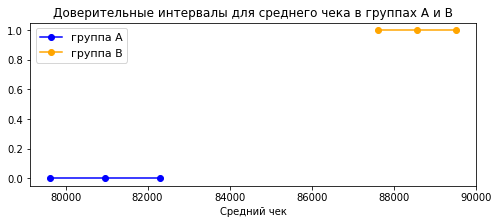

In [45]:
display_confidence_intervals(
    a_lower, a_upper,
    b_lower, b_upper,
    'Доверительные интервалы для среднего чека в группах A и B',
    'Средний чек',
)

> Доверительные интервалы в группах не пересекаются.\
Значит с 95%-й вероятностью истинные средние значения чеков в группах не совпадают.\
Этот же результат мы получили выше с помощью статистического теста.

## Общий вывод по результатам A/B теста <a class="anchor" id="results"></a>

По результатам исследования мы получили, что:

- По метрике конверсии группы A и B не различаются
- По метрике среднего чека в группе B результат выше, чем в группе A.

> Отсюда можно сделать вывод, что предпочтительнее использовать вариант посадочной страницы B.

Также было замечено, что с посадочной страницы варианта B  больше покупают туров в Тайланд.\
А с посадочной страницы группы A  больше покупают туров в Турцию.

Возможно, стоит проанализировать содержимое страниц, чтобы понять причину этой разницы \
(если конечно, страницы изначально не были сделаны с таким расчетом и данный результат не является неожиданностью).